```
円形範囲内の敵に対して、爆弾１個を投擲しダメージを与えます。
銃弾：攻撃力の441%分のダメージ
電界：攻撃力の421%分のダメージ
爆炎：攻撃力の398%分のダメージ
```



```
Exスキルの発動と同時に、使用した爆弾の種類によって攻撃力を増加(40秒間)
銃弾：攻撃力を29.1%増加
電界：攻撃力を27.5%増加
爆炎：攻撃力を26%増加
```

## Initialize

In [ ]:
!pip install -q japanize-matplotlib

In [ ]:
import copy
import random
from easydict import EasyDict
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import matplotlib.ticker as ticker


def calc_stability_lb(stability: int) -> float:
    return stability/(stability+1000) + 0.2


def calc_critical_prob(cr: float, crr: float):
    return (cr - crr)/(cr - crr + 666.66)


def calc_critical_dmg(critical_prob: float, cd: float, cdr: float) -> bool:
    if random.random() <= critical_prob: # 会心発生
        return cd - cdr
    else: # 非会心
        return 1.0


def ROUNDDOWN(number: float, digits: int) -> float:
    '''Excel-like function'''
    factor = 10 ** digits
    return np.floor(number * factor) / factor


def ROUND(number: float, num_digits: int) -> float:
    '''Excel-like function'''
    return np.round(number, num_digits)

## 各種変数

In [ ]:
from collections import defaultdict

def calc_aggregated_buffs(buffs: dict):
    variables = ['atk', 'cr', 'cd']
    aggregated_buffs = defaultdict(lambda: {'num': 0, 'per': 0})

    for buff in buffs:
        for k, v in buff.items():
            aggregated_buffs[k]['num'] += v[0]
            aggregated_buffs[k]['per'] += v[1]

    return EasyDict(aggregated_buffs)

In [ ]:
def select_params(buffs_use: list, enemy_name: str):
    # cr: 会心値, cd: 会心ダメージ率
    # crr: 会心抵抗率, cdr: 会心ダメージ抵抗率

    status = EasyDict({ # wo equipments
        "atk": 5000, # definitive value for easy caluculation
        "stability": 1332, # 安定値
        #"accuracy": 104, # 命中値
        "cr": 209,
        "cd": 200,
        "field_affinity": [0.8, 1.0, 1.2, 1.3][1],
        "enemy_armor_affinity": 2, # 敵が特殊装甲想定
        "lv_decay": 1-0.02*5, # 10%カット
    })

    buff_dict = {# (numerical [+], percentage [%])
        "Koyuki_PS": {"atk": (False, 0.266),},
        # equipments
        "glove_T8": {"atk": (False, 0.4), "cr": (370, False),},
        "watch_T8": {"cr": (400, False), "cd": (2400/100, False)},
        # others
        "Fuuka_EX_SS": {"atk": (False, 0.173), "cd": (False, 0.321),},
        "Ako_EX_SS": {"cr": (False, 0.395), "cd": (False, 0.173+0.733),}, # 味方1人に対して、会心値を39.5%増加。さらに会心ダメージ率を73.3%増加（16秒間） / 味方の会心ダメージ率を17.3%増加
        "SerinaC_EX": {"cd": (False, 0.435),},
        "Himari_EX": {"atk": (False, 1.05), },
        "general_cd_SS": {"cd": (False, 0.173)},
    }

    buffs = []
    for k, v in buff_dict.items():
        if(k in buffs_use):
            buffs.append(v)
    aggregated_buffs = calc_aggregated_buffs(buffs)

    enemy = EasyDict({
        # ペロロジラTorment
        "Peroro":           {"defense": 7000, "crr": 100, "cdr": 0.8},
        "Perorominion":    {"defense": 6000, "crr": 100, "cdr": 0.8},
        "miniPeroro":       {"defense": 2000, "crr": 100, "cdr": 0.8},
        # ゴズ
        "Goz":              {"defense": 100, "crr": 500, "cdr": 0.5},
        "GozKuma":          {"defense": 989, "crr": 100, "cdr": 0.5}, # https://twitter.com/SLC_Sil/status/1636358546169409536?s=20
        # ケセド (大決戦想定)
        "ChesedSweeper": {"defense": 82, "crr": 20, "cdr": 0.5}, # https://twitter.com/SLC_Sil/status/1646880223819104257?s=20
        "ChesedDrone": {"defense": 109, "crr": 20, "cdr": 0.5},
        "ChesedCannon": {"defense": 55, "crr": 20, "cdr": 0.5},
        "ChesedHumanoid": {"defense": 82, "crr": 20, "cdr": 0.5},
        "ChesedGoliath": {"defense": 82, "crr": 20, "cdr": 0.5},
        # 回転(大決戦想定)
        "Kaitenjars": {"defense": int((1332+333*4)/5), "crr": 100, "cdr": 0.8},
    })[enemy_name]

    return status, aggregated_buffs, enemy

## 定数

In [ ]:
def define_params(specials, enemy_name):
    buffs_use = [
        "Koyuki_PS",
        "glove_T8",
        "watch_T8",
        * [key for key, value in specials.items() if value]
    ]

    status, aggregated_buffs, enemy = select_params(
        buffs_use=buffs_use,
        enemy_name=enemy_name
    )

    return {
        'status': status,
        'buffs': aggregated_buffs,
        'enemy': enemy
    }

In [ ]:
def calc_dmg(n_trials: int,
        ex: dict,
        slb: float,
        atk: int,
        cr: float,
        cd: float,
        critical_prob: float,
        calibrating_value: float,
        dmg_cut: float
        ) -> int:
    # 会心判定ベクトル
    #critical_vec = np.random.uniform(low=0.0, high=1.0, size=ex.n)
    critical_vec = np.random.uniform(low=0.0, high=1.0, size=[ex.n, n_trials]) # [n, trials]
    critical_dmg_vec = np.where(critical_vec <= critical_prob, cd, 1) # cond, True, False

    """
    atk_with_skill = int(atk * ex.factor) # スキル攻撃力=攻撃力x威力
    atk_with_stability = np.random.randint(low=int(atk_with_skill * slb), high=atk_with_skill, size=ex.n)#dmg_vec = (base_dmg * stability_vec).astype(int) # 基礎ダメ*乱数, 厳密には式は異なる
    atk_calibrated = atk_with_stability * calibrating_value
    atk_with_cut = atk_calibrated/dmg_cut # 防御倍率
    atk_with_critical = ROUND(critical_dmg_vec * atk_with_cut, 4) # 会心倍率
    atk_divided = atk_with_critical / ex.n # 分割率（たぶん厳密には違う）
    total_dmg = int(np.sum(atk_divided))
    if(False): # 内訳
        print("敵防御倍率", dmg_cut)
        print(f"バフ込み会心値: {cr:.1f}, バフ込み会心ダメ率: {cd}, 会心確率: {critical_prob:.4f}")
        print(f"バフ込攻撃力: {atk}, スキル倍率: {atk_with_skill}, 乱数込み: {atk_with_stability}, 補正込み: {atk_calibrated}")
        print(f"防御倍率込: {atk_with_cut}, 会心倍率込: {atk_with_critical}, 分割率: {atk_divided}")
        print(f"合計ダメージ: {total_dmg}")
    """
    atk_with_skill = int(atk * ex.factor) # スキル攻撃力=攻撃力x威力
    atk_with_stability = np.random.randint(low=int(atk_with_skill * slb), high=atk_with_skill, size=[ex.n, n_trials])#dmg_vec = (base_dmg * stability_vec).astype(int) # 基礎ダメ*乱数, 厳密には式は異なる
    atk_calibrated = atk_with_stability * calibrating_value
    atk_with_cut = atk_calibrated/dmg_cut # 防御倍率
    atk_with_critical = ROUND(critical_dmg_vec * atk_with_cut, 4) # 会心倍率
    atk_divided = atk_with_critical / ex.n # 分割率（たぶん厳密には違う）
    total_dmg = np.sum(atk_divided, axis=0).astype(int)
    print(total_dmg.shape)


    return total_dmg

In [ ]:
def calc_dmgs(n_trials: int,
              ex: dict,
              status: dict, buffs: dict, enemy: dict) -> list:
    # 乱数の初期化, 再現性の担保
    random.seed(42)
    np.random.seed(42)

    # 定数の計算
    slb = calc_stability_lb(status.stability)
    atk = ROUND((status.atk + buffs.atk.num) * (1 + buffs.atk.per + ex.atk_buff), 0)
    cr = (status.cr + buffs.cr.num) * (1 + buffs.cr.per)
    cd = ROUND((status.cd + buffs.cd.num) * (1 + buffs.cd.per) /100, 4) # 会心ダメージ率の表記は1/100する必要あり
    critical_prob = calc_critical_prob(cr, enemy.crr)
    dmg_cut = ROUNDDOWN((1666.66+enemy.defense)/1666.66, 4)
    calibrating_value = ROUNDDOWN(ROUNDDOWN(
                            status.lv_decay * status.enemy_armor_affinity, 4)*status.field_affinity, 4
                        ) # 補正倍率(装甲→地形→レベル差)

    return calc_dmg(n_trials, ex, slb=slb, atk=atk, cr=cr, cd=cd, critical_prob=critical_prob, calibrating_value=calibrating_value, dmg_cut=dmg_cut)

## plot

In [86]:
def plot(dmgs_explosion, dmgs_bullets, dmgs_discharging):
    plot_params_explosion = {"bomb_type": "Explosion","color": "red"}
    plot_params_bullets = {"bomb_type": "Bullets","color": "orange"}
    plot_params_discharging = {"bomb_type": "Discharging","color": "blue"}

    max_damage = 100000
    n_xticks = 21
    max_frequency = 10000
    n_yticks = 11
    fontsizes = {
        "title": 24,
        "label": 24,
        "ticks": 12,
        "legend": 12,
    }

    bins = range(0, max_damage, max_damage//200)

    plt.figure(figsize=(12, 8), dpi=150)

    def plot_hist(dmgs: np.ndarray, params: dict):
        plt.hist(dmgs, bins=bins, rwidth=0.8, alpha=0.2, color=params["color"], label=params["bomb_type"], edgecolor='darkred', histtype="stepfilled")
        #plt.axvline(x=dmgs.mean(), label=f"{params['bomb_type']}(mean): {dmgs.mean():.1f}", color=params["color"], linestyle='dotted')
        plt.axvline(x=np.median(dmgs), label=f"{params['bomb_type']}(median): {np.median(dmgs):.1f}", color=params["color"], linestyle='dashed')

    plot_hist(dmgs_explosion, plot_params_explosion)
    plot_hist(dmgs_bullets, plot_params_bullets)
    plot_hist(dmgs_discharging, plot_params_discharging)

    plt.xlabel('ダメージ', fontsize=fontsizes["label"])
    plt.ylabel('頻度', fontsize=fontsizes["label"])
    plt.title("""コユキEX: "トリッキーな変数" """, fontsize=fontsizes["title"])
    plt.legend(loc="upper right", fontsize=fontsizes["legend"])

    plt.gca().get_xaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    plt.gca().get_yaxis().set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    plt.xticks([i*(max_damage//(n_xticks-1)) for i in range(n_xticks)], rotation=45, fontsize=fontsizes["ticks"])
    plt.yticks([i*(max_frequency//(n_yticks-1)) for i in range(n_yticks)], fontsize=fontsizes["ticks"])
    plt.xlim([0, max_damage])
    plt.ylim([0, max_frequency])
    #plt.text(6, 1000, 'アコヒマリ', ha='center', va='center')
    plt.show()
    plt.close()

SPECIAL:  {'Fuuka_EX_SS': True, 'Ako_EX_SS': False, 'SerinaC_EX': False, 'Himari_EX': True, 'general_cd_SS': False}
仮想敵 Perorominion
params:  {'status': {'atk': 5000, 'stability': 1332, 'cr': 209, 'cd': 200, 'field_affinity': 1.0, 'enemy_armor_affinity': 2, 'lv_decay': 0.9}, 'buffs': {'atk': {'num': 0, 'per': 1.889}, 'cr': {'num': 770, 'per': 0}, 'cd': {'num': 24.0, 'per': 0.321}}, 'enemy': {'defense': 6000, 'crr': 100, 'cdr': 0.8}}
(100000,)
(100000,)
(100000,)


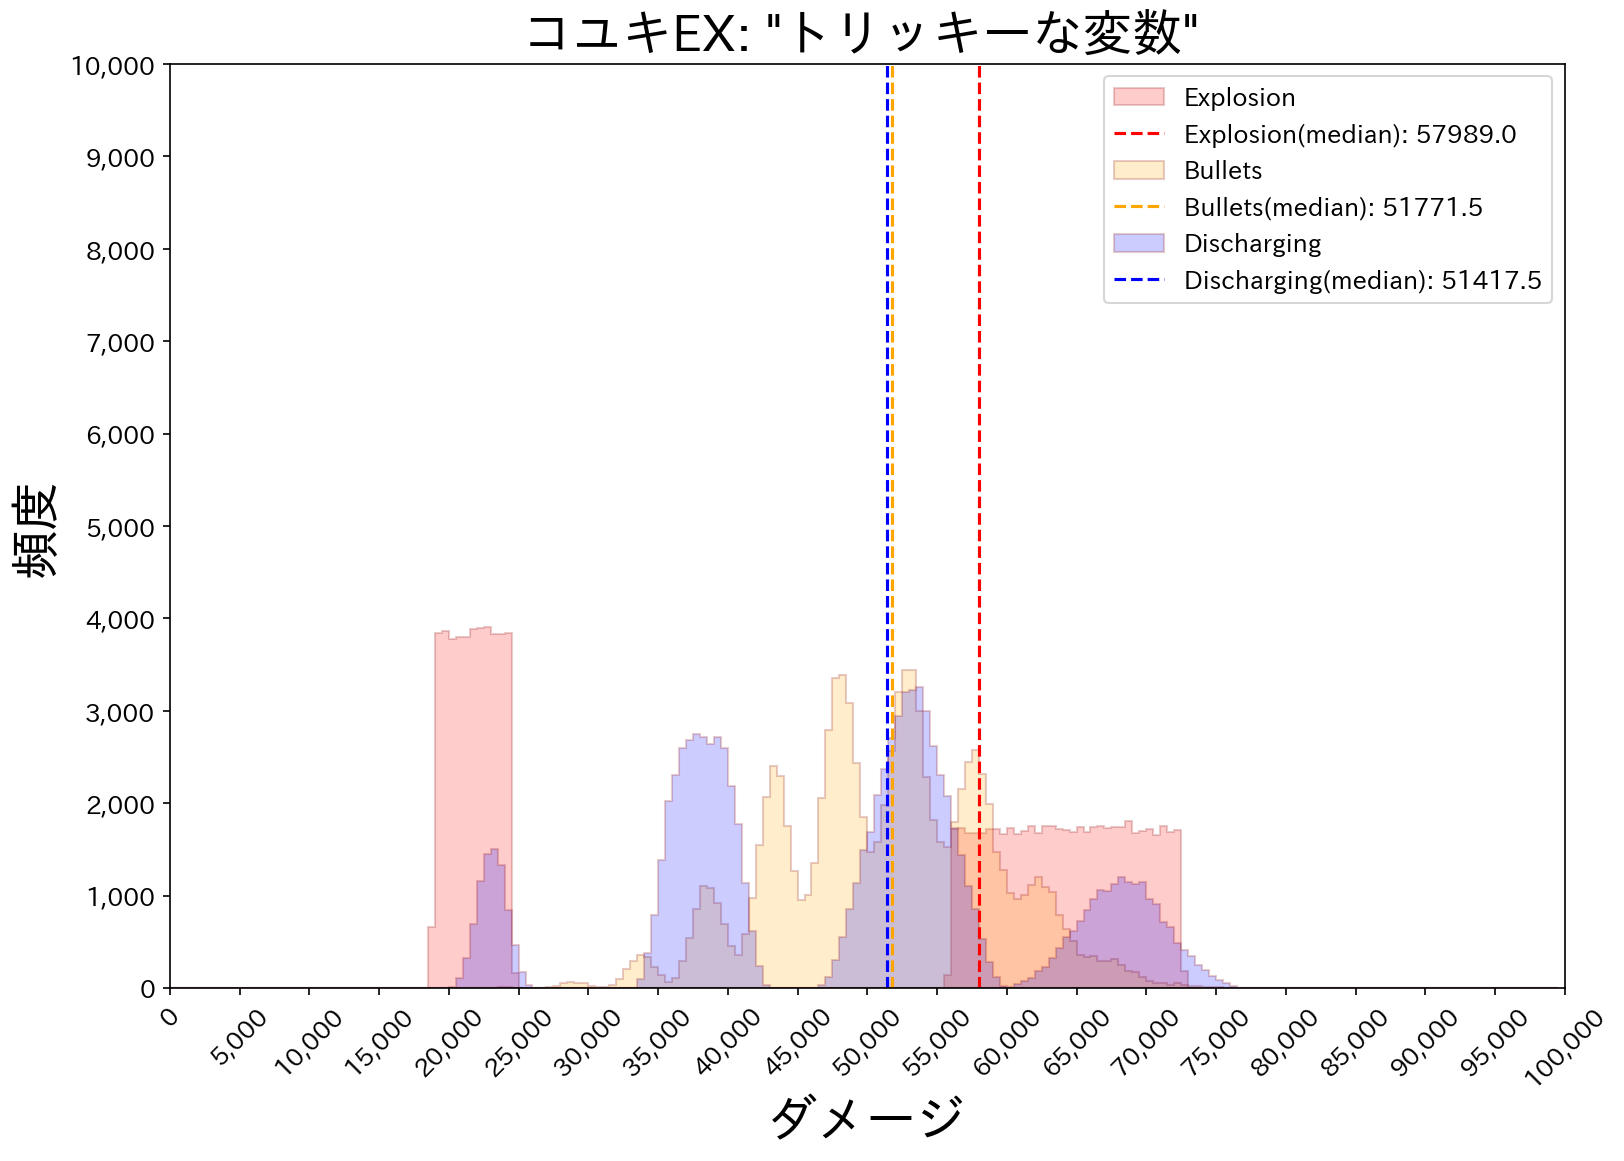

In [93]:
n_trials = 100000
ex_params = EasyDict({
    "bullets": {'n': 10, 'factor': 4.41, 'atk_buff': 0.291},
    "discharging": {'n': 3, 'factor': 4.21, 'atk_buff': 0.275},
    "explosion": {'n': 1, 'factor': 3.98, 'atk_buff': 0.260},
})

# ["Peroro", "Perorominion", "miniPeroro", "Goz", "GozKuma", "ChesedSweeper", "ChesedDrone", "ChesedCannon", "ChesedHumanoid", "ChesedGoliath", "Kaitenjars"]
enemy_name = "Perorominion"

specials = {
    "Fuuka_EX_SS": True,
    "Ako_EX_SS": False,
    "SerinaC_EX": False,
    "Himari_EX": True,
    "general_cd_SS": False,
}
params = define_params(specials, enemy_name)
print("SPECIAL: ", specials)
print("仮想敵", enemy_name)
print("params: ", params)


dmgs_bullets = np.asarray(calc_dmgs(n_trials=n_trials, ex=ex_params.bullets, **params))
dmgs_discharging = np.asarray(calc_dmgs(n_trials=n_trials, ex=ex_params.discharging, **params))
dmgs_explosion = np.asarray(calc_dmgs(n_trials=n_trials, ex=ex_params.explosion, **params))
plot(dmgs_explosion, dmgs_bullets, dmgs_discharging)

In [88]:
calc_critical_prob(cr=979, crr=100)

0.5686891036838633

## 安定値グラフ


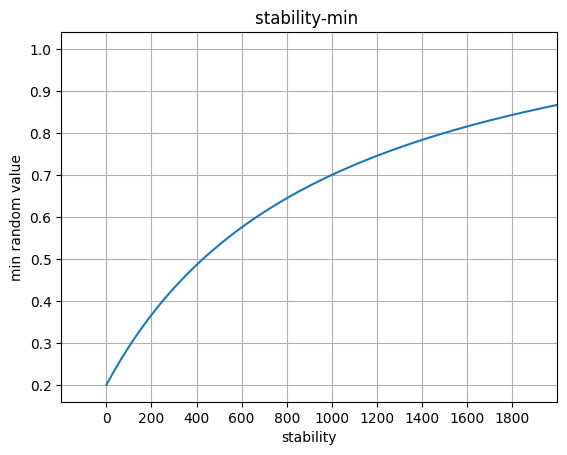

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def f(s):
    return s / (s + 1000) + 0.2

x = np.linspace(0, 4000, 1000)
y = f(x)

# グラフを描画
plt.plot(x, y)
plt.xticks([i*200 for i in range(10)])
plt.xlabel('stability')
plt.xlim(right=2000)
plt.ylabel('min random value')
plt.title('stability-min ')
plt.grid(True)

# グラフを表示
plt.show()

## 投擲チェック

In [ ]:
!pip install -q japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


a: 3.2392, b: 22.1354
a: 3.2392, b: 41.1354
a: 4.0060, b: 18.2048
コハルEXを完全に追い抜く距離: 2242.73[射程]


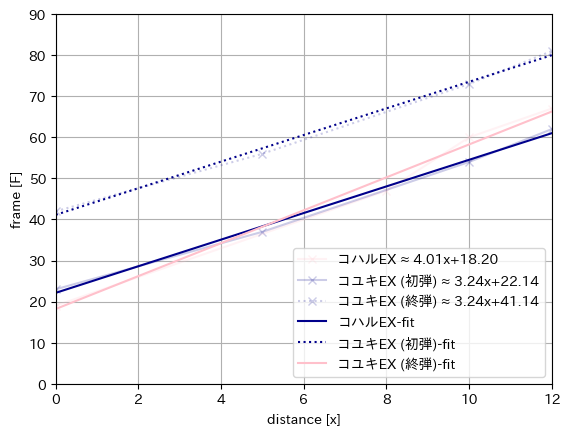

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.optimize import curve_fit

"""
観測済みパラメータ
"""
# 投擲に何フレームかかっているか
x_koyuki = [0, 5, 10, 12] # distance / 10 が射程750-ホドの距離
t_koyuki1 = [23, 37, 54, 62]
t_koyuki2 = [42, 56, 73, 81]

# コハルはEX範囲が狭いので刻みが違う
x_koharu = [0, 8, 10, 12]
t_koharu = [19, 47, 60, 67]

# １次関数のパラメータ
list_a = []
list_b = []

"""最小二乗法の実行
"""
for (x, t) in zip([x_koyuki, x_koyuki, x_koharu], [t_koyuki1, t_koyuki2, t_koharu]):
    (a, b), _ = curve_fit(lambda x, a, b: a*x + b, x, t, p0=[1.0, 1.0])
    print(f"a: {a:.4f}, b: {b:.4f}")
    list_a.append(a)
    list_b.append(b)




# コハルがコユキを追い越すのはピラー3.04距離分(=750*3.04=2280)
"""逆転地点
a_1*x + b_1 = a_2*x + b_2
(b_1 - b_2) = (a_2 - a_1) * x
↔ x = (b_1 - b_2)/(a_2 - a_1)
"""
crossing_point = (list_b[2] - list_b[1])/(list_a[1] - list_a[2])
d_turning = crossing_point / 10 * 750
print(f"コハルEXを完全に追い抜く距離: {d_turning:.2f}[射程]")

"""グラフ描画
"""
if(True):
    alpha = 0.2
    plt.plot(x_koharu, t_koharu, marker='x', color="pink", label=f'コハルEX ≈ {list_a[2]:.2f}x+{list_b[2]:.2f}', alpha=alpha)
    plt.plot(x_koyuki, t_koyuki1, marker='x', color='darkblue', label=f'コユキEX (初弾) ≈ {list_a[0]:.2f}x+{list_b[0]:.2f}', linestyle="solid", alpha=alpha)
    plt.plot(x_koyuki, t_koyuki2, marker='x', color='darkblue', label=f'コユキEX (終弾) ≈ {list_a[1]:.2f}x+{list_b[1]:.2f}', linestyle="dotted", alpha=alpha)
if(True):
    alpha = 1.0
    # predicted-lines
    x = np.linspace(0, 12, 1000)
    y1 = list_a[0]*x + list_b[0]
    y2 = list_a[1]*x + list_b[1]
    y3 = list_a[2]*x + list_b[2]

    plt.plot(x, y1, label="コハルEX-fit", color='darkblue', alpha=alpha, linestyle="solid")
    plt.plot(x, y2, label="コユキEX (初弾)-fit", color='darkblue', alpha=alpha, linestyle="dotted")
    plt.plot(x, y3, label="コユキEX (終弾)-fit", color='pink', alpha=alpha)

plt.xlim(0, 12)
plt.ylim(0, 90)
plt.xlabel('distance [x]') # 10で750射程のピラーまでの距離
plt.ylabel('frame [F]')
plt.legend()
plt.grid(True)
plt.show()